<a href="https://colab.research.google.com/github/tegaryas/Multi_Klasifikasi_Deteksi_Covid_19_dan_Penumonia_dengan_Gambar_X_Ray_Paru/blob/main/Deteksi_Covid_19_X_Ray_Paru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install lime

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from matplotlib import pyplot
from tensorflow.keras.applications import VGG16,InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.segmentation import mark_boundaries
import cv2
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from keras.utils.vis_utils import plot_model

# **CNN from VGG16 dan InceptionV3 model**

In [ ]:
inception = InceptionV3(input_shape=(224,224,3),include_top=False,weights='imagenet')

87916544/87910968 [==============================] - 0s 0us/step


In [ ]:
inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
print("Total Number of layers in vgg_model: ",len(inception.layers))

Total Number of layers in vgg_model:  311


Setting model menjadi non trainable dan menambahkan 3 layer lagi untuk prediksi penyakit ini dengan 3 klasifikasi

In [ ]:
for i in inception.layers:
  i.trainable=False

In [ ]:
x = Flatten()(inception.output)
prediction = Dense(3,activation='softmax')(x)

inception_model = Model(inputs=inception.input,outputs=prediction)


In [ ]:
inception_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

## **Visualisasi Arsitektur Model**

In [ ]:
plot_model(inception_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# **Train Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
TRAIN_PATH = "/content/drive/My Drive/COVID-19_Radiography_Dataset/Train"
TEST_PATH = "/content/drive/My Drive/COVID-19_Radiography_Dataset/Test"
VALID_PATH = "/content/drive/My Drive/COVID-19_Radiography_Dataset/Validation"

### **Data Augmentation**

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True
                                   )

test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_data = train_datagen.flow_from_directory(TRAIN_PATH,
                                              target_size=(224,224),
                                              batch_size=32,
                                              class_mode='categorical')

test_data = test_datagen.flow_from_directory(TEST_PATH,
                                              target_size=(224,224),
                                              batch_size=32,
                                              class_mode='categorical')

valid_data = valid_datagen.flow_from_directory(VALID_PATH,
                                              target_size=(224,224),
                                              batch_size=32,
                                              class_mode='categorical')

Found 1121 images belonging to 3 classes.
Found 51 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


In [ ]:
test_data.class_indices

{'Covid': 0, 'Normal': 1, 'Pneumonia': 2}

### **Train The Model**

Compile Model dengan "Adam" Optimizer

In [ ]:
inception_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history = inception_model.fit(train_data,
              steps_per_epoch=len(train_data),
              epochs=30,
              validation_data=valid_data,
              validation_steps=len(valid_data))

Epoch 1/30
36/36 [==============================] - 18s 407ms/step - loss: 5.3710 - accuracy: 0.6735 - val_loss: 1.7335 - val_accuracy: 0.8167
Epoch 2/30
36/36 [==============================] - 14s 375ms/step - loss: 1.2385 - accuracy: 0.8501 - val_loss: 1.7473 - val_accuracy: 0.8167
Epoch 3/30
36/36 [==============================] - 14s 375ms/step - loss: 0.9049 - accuracy: 0.8805 - val_loss: 1.4711 - val_accuracy: 0.8500
Epoch 4/30
36/36 [==============================] - 13s 373ms/step - loss: 1.5224 - accuracy: 0.8368 - val_loss: 4.1848 - val_accuracy: 0.6833
Epoch 5/30
36/36 [==============================] - 13s 373ms/step - loss: 1.1952 - accuracy: 0.8760 - val_loss: 1.6549 - val_accuracy: 0.8500
Epoch 6/30
36/36 [==============================] - 14s 380ms/step - loss: 0.7355 - accuracy: 0.9010 - val_loss: 0.4854 - val_accuracy: 0.9333
Epoch 7/30
36/36 [==============================] - 13s 382ms/step - loss: 3.7649 - accuracy: 0.8189 - val_loss: 3.7004 - val_accuracy: 0.8333

In [ ]:
results = inception_model.evaluate(test_data)
print("Loss: ",results[0],)
print("Accuracy: ",results[1]*100, '%')

2/2 [==============================] - 1s 286ms/step - loss: 0.6888 - accuracy: 0.9216
Loss:  0.6888189315795898
Accuracy:  92.15686321258545 %


In [ ]:
import sys
sys.path.append("/content/drive/My Drive/COVID-19_Radiography_Dataset/")
inception_model.save("/content/drive/My Drive/COVID-19_Radiography_Dataset/CNN_Covid19_Inception_Model.h5")
print("Model Udah di Save Yaks")

Model Udah di Save Yaks


# **Confusion Matrix**

In [ ]:
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
test_data.class_indices

{'Covid': 0, 'Normal': 1, 'Pneumonia': 2}

In [ ]:

y_true = []
y_test = []

for i in os.listdir("/content/drive/My Drive/COVID-19_Radiography_Dataset/Test/Covid/"):
    img = load_img("/content/drive/My Drive/COVID-19_Radiography_Dataset/Test/Covid/"+i, target_size=(224,224))
    img = img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0)
    p = inception_model.predict(img)
    p = np.argmax(p)
    y_test.append(p)
    y_true.append(0)

In [ ]:
for i in os.listdir("/content/drive/My Drive/COVID-19_Radiography_Dataset/Test/Normal/"):
    img = load_img("/content/drive/My Drive/COVID-19_Radiography_Dataset/Test/Normal/"+i, target_size=(224,224))
    img = img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0)
    p = inception_model.predict(img)
    p = np.argmax(p)
    y_test.append(p)
    y_true.append(1)

In [ ]:
for i in os.listdir("/content/drive/My Drive/COVID-19_Radiography_Dataset/Test/Pneumonia/"):
    img = load_img("/content/drive/My Drive/COVID-19_Radiography_Dataset/Test/Pneumonia/"+i, target_size=(224,224))
    img = img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0)
    p = inception_model.predict(img)
    p = np.argmax(p)
    y_test.append(p)
    y_true.append(2)

In [ ]:
Confusion_Matrix = confusion_matrix(y_true,y_test)

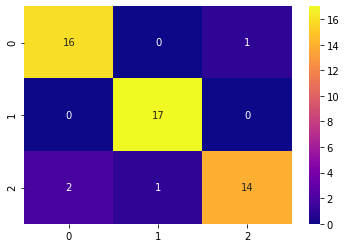

In [ ]:
sns.heatmap(Confusion_Matrix,cmap='plasma',annot=True)

In [ ]:
cls_report_print= classification_report(y_true,y_test, target_names=test_data.class_indices)

In [ ]:
print("-"*90)
print(cls_report_print)
print("-"*90)

------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

       Covid       0.89      0.94      0.91        17
      Normal       0.94      1.00      0.97        17
   Pneumonia       0.93      0.82      0.87        17

    accuracy                           0.92        51
   macro avg       0.92      0.92      0.92        51
weighted avg       0.92      0.92      0.92        51

------------------------------------------------------------------------------------------


# **Visualisasi History dari Accuracy dan Loss**

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))

Text(0.5, 1.0, 'Training and Validation loss')

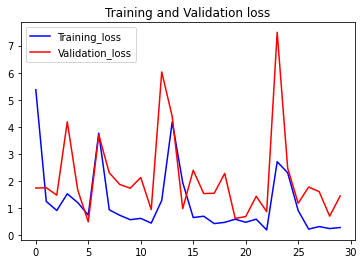

In [ ]:
plt.plot(epochs,loss,label='Training_loss',color='blue')
plt.plot(epochs,val_loss,label='Validation_loss',color='red')
plt.legend()
plt.title("Training and Validation loss")

Text(0.5, 1.0, 'Training and Validation Accuracy')

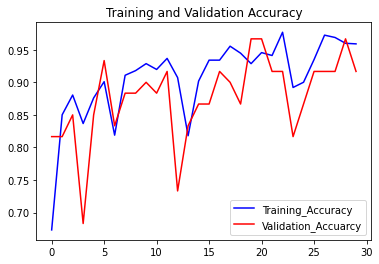

In [ ]:
plt.plot(epochs,acc,label='Training_Accuracy',color='blue')
plt.plot(epochs,val_acc,label='Validation_Accuarcy',color='red')
plt.legend()
plt.title("Training and Validation Accuracy")

# **Hasil Prediksi dengan X-Ray Images**

In [ ]:
def img_predict(path):
    img = load_img(path,target_size=(224,224))
    plt.imshow(img)
    img = img_to_array(img)
    img = img/255
    img = np.expand_dims(img,axis=0)
    pred = inception_model.predict(img)
    
    print("\n")
    print("Covid-19 : ",pred[0][0]*100,"%")
    print("Normal   : ",pred[0][1]*100,"%")
    print("Pneumonia: ",pred[0][2]*100,"%")



Covid-19 :  4.5021749404745056e-24 %
Normal   :  3.586022145896095e-07 %
Pneumonia:  100.0 %


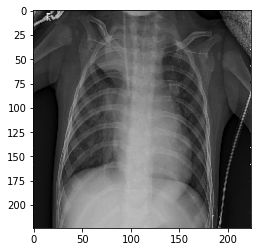

In [ ]:
img_predict('/content/drive/My Drive/COVID-19_Radiography_Dataset/Test/Pneumonia/person25_bacteria_117.jpeg')
#img_predict('/content/drive/My Drive/COVID-19_Radiography_Dataset/Test/Covid/auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg')
#img_predict('/content/drive/My Drive/COVID-19_Radiography_Dataset/Test/Normal/IM-0578-0001.jpeg')

In [ ]:
class_dict = {0:'COVID',
              1:'NORMAL',
              2:'PNEUMONIA'}

In [ ]:
def find_true_class(path):
    true_class = None
    if 'Covid' in path:
        true_class = 'COVID'
    elif 'Normal' in path:
        true_class = 'NORMAL'
    elif 'Pneumonia' in path:
        true_class = 'PNEUMONIA'
        return true_class

In [ ]:
def visualize(path,ax,text_loc):
    img = load_img(path,target_size=(224,224))
    img = img_to_array(img)
    img = img/255
    img = np.expand_dims(img,axis=0)
    pred = inception_model.predict(img)
    pred_class = np.argmax(pred)
    pred_class = class_dict[pred_class]


    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(img[0], inception_model.predict, top_labels=5, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)


    ax.imshow(mark_boundaries(temp, mask))
    fig.text(text_loc, 0.9, "Predicted Class: " + pred_class , fontsize=13)
    true_class = find_true_class(path)
    if true_class is not None:
        fig.text(text_loc, 0.86, "Actual Class: " + true_class , fontsize=13)

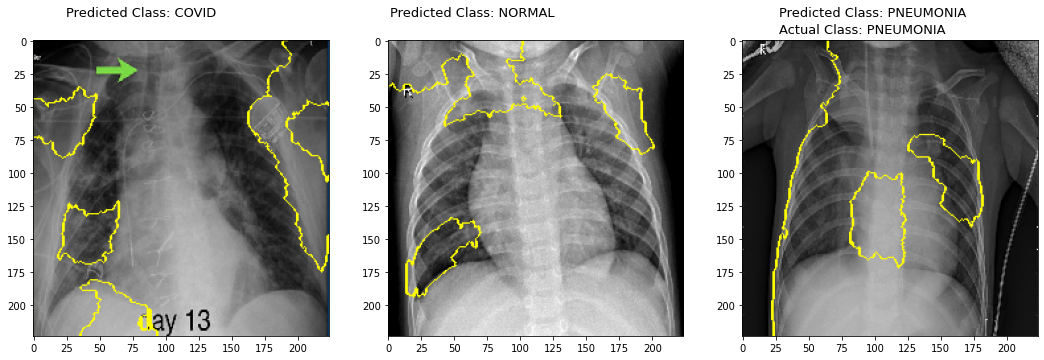

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(18,6))
visualize('/content/drive/My Drive/COVID-19_Radiography_Dataset/Test/Covid/extubation-13.jpg',ax[0],0.15)
visualize('/content/drive/My Drive/COVID-19_Radiography_Dataset/Test/Normal/IM-0706-0001.jpeg',ax[1],0.4)
visualize('/content/drive/My Drive/COVID-19_Radiography_Dataset/Test/Pneumonia/person25_bacteria_117.jpeg',ax[2],0.7)